### Spark приклад

#### Операції (трансформації та дії) в PySpark

In [0]:
# Завантажуємо необхідні методи
from pyspark.sql.functions import col, sum

# Створюємо навчальні дані
data = [("Alice", 34, 5000), ("Bob", 45, 6000), ("Cathy", 29, 4000), ("David", 34, 7000)]
columns = ["Name", "Age", "Salary"]

# Створюємо Spark DataFrame
df = spark.createDataFrame(data, columns)

# Трансформації / Transformations
df_filtered = df.filter(col("Age") > 30)
df_with_bonus = df_filtered.withColumn("Bonus", col("Salary") * 0.10)
df_total = df_with_bonus.groupBy("Age").agg(sum("Bonus").alias("TotalBonus"))

In [0]:
# Дія / Action
df_total.show()

+---+----------+
|Age|TotalBonus|
+---+----------+
| 34|    1200.0|
| 45|     600.0|
+---+----------+



#### Аналогічний код в Python Pandas

In [0]:
import pandas as pd

# Load sample data
data = [("Alice", 34, 5000), ("Bob", 45, 6000), ("Cathy", 29, 4000), ("David", 34, 7000)]
columns = ["Name", "Age", "Salary"]

df = pd.DataFrame(data, columns=columns)

# "Transformations"
df_filtered = df[df["Age"] > 30]
df_with_bonus = df_filtered.copy()
df_with_bonus["Bonus"] = df_with_bonus["Salary"] * 0.10
df_total = df_with_bonus.groupby("Age")["Bonus"].sum().reset_index(name="TotalBonus")

In [0]:
# "Action"
df_total

,Age,TotalBonus
0,34,1200.0
1,45,600.0


#### Завантаження датасету

In [0]:
df = spark.read.parquet("dbfs:/FileStore/tables/tracks.parquet")

#### Знайомство з функцією <code>display()</code>

In [0]:
# Отримуємо загальні відомості про датасет:
display(df)
# Використовуємо додатковий функціонал для отримання інформації про розподіл характеристик датасету

#### Задача № 1. Обчислити кількість треків у даному датасеті та кількість унікальних виконавців. Результат зобразити в діаграмі та нанести на дашборд.

In [0]:
from pyspark.sql.functions import split, explode, col, trim, regexp_replace

# Обчислення загальної кількості треків
total_tracks = df.count()

# Розділити колонку 'artists' на окремі виконавці та створити нову колонку
df_artists = df.withColumn("artist", explode(split(col("artists"), ",")))

# Видалити зайві символи (квадратні дужки, лапки та пробіли)
df_artists = df_artists.withColumn("artist", trim(regexp_replace(col("artist"), "[\\[\\]']", "")))

# Обчислення кількості унікальних виконавців
unique_artists = df_artists.select("artist").distinct().count()

In [0]:
# Дані для DataFrame
data = [[total_tracks, unique_artists]]
columns = ["Total_number_of_tracks", "Total_number_of_artists"]
# Створення DataFrame зі списку значень
stats_to_display = spark.createDataFrame(data, columns)
display(stats_to_display)

Total_number_of_tracks,Total_number_of_artists
586672,96431


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

#### Задача № 2. Обчислити середні значення характеристик треків. З'ясувати чи середні значення популярних треків відрізняються від загальних середніх.

In [0]:
from pyspark.sql.functions import avg, col, lit

# Список колонок для агрегації
columns_to_aggregate = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
                        "instrumentalness", "liveness", "valence", "tempo", "popularity"]

# Агрегація середніх значень характеристик для всіх треків
overall_aggregations = [avg(col).alias(f"avg_{col}") for col in columns_to_aggregate]
overall_stats = df.agg(*overall_aggregations)
overall_stats = overall_stats.withColumn("category", lit("Overall"))

In [0]:
display(overall_stats)

avg_danceability,avg_energy,avg_loudness,avg_speechiness,avg_acousticness,avg_instrumentalness,avg_liveness,avg_valence,avg_tempo,avg_popularity,category
0.5635938180107591,0.5420359919116704,-10.206066809051883,0.10486354180871624,0.44986272444745107,0.11345078218816747,0.21393501687483635,0.5522924730805054,118.46485662687292,27.570052772247525,Overall


In [0]:
# Визначення популярних треків (припустимо, популярність вище 80)
popular_threshold = 80
popular_tracks = df.filter(col("popularity") > popular_threshold)

# Агрегація середніх значень характеристик для популярних треків
popular_aggregations = [avg(col).alias(f"avg_{col}") for col in columns_to_aggregate]
popular_stats = popular_tracks.agg(*popular_aggregations)
popular_stats = popular_stats.withColumn("category", lit("Popular"))

In [0]:
# Об'єднання результатів у єдиний DataFrame для порівняння
comparison_df = overall_stats.union(popular_stats)
# Відображення результату
comparison_df.show()

+------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+--------+
|  avg_danceability|        avg_energy|       avg_loudness|    avg_speechiness|   avg_acousticness|avg_instrumentalness|       avg_liveness|       avg_valence|         avg_tempo|    avg_popularity|category|
+------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+--------+
|0.5635938180107591|0.5420359919116704|-10.206066809051883|0.10486354180871624|0.44986272444745107| 0.11345078218816747|0.21393501687483635|0.5522924730805054|118.46485662687292|27.570052772247525| Overall|
|0.6738817934782607|0.6387163315217393| -6.347464673913044| 0.1011036684782609| 0.2403651542119562|0.011630222214673908|  0.171176222826087|0.5154885869565221| 121.13315760

In [0]:
display(comparison_df)

avg_danceability,avg_energy,avg_loudness,avg_speechiness,avg_acousticness,avg_instrumentalness,avg_liveness,avg_valence,avg_tempo,avg_popularity,category
0.5635938180107591,0.5420359919116704,-10.206066809051883,0.10486354180871624,0.44986272444745107,0.11345078218816747,0.21393501687483635,0.5522924730805054,118.46485662687292,27.570052772247525,Overall
0.6738817934782607,0.6387163315217393,-6.347464673913044,0.1011036684782609,0.2403651542119562,0.011630222214673908,0.171176222826087,0.5154885869565221,121.1331576086956,83.98233695652173,Popular


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

#### Задача № 3. Підрахувати кількість треків випущених кожного року

In [0]:
from pyspark.sql.functions import year

# Додавання колонки з роком випуску
df = df.withColumn("release_year", year("release_date"))

# Групування за роками та обчислення кількості треків
tracks_per_year = df.groupBy("release_year").count().orderBy("release_year")

In [0]:
display(tracks_per_year)

#### Задача №4. Обчислити частку треків які мають explicit контент та зобразити на діаграмі Pie. Зʼясувати як відрізняється популярність треків для треків з explicit контентом

In [0]:
from pyspark.sql.functions import avg, count, col

agg_df = df.groupBy("explicit").agg(
    count("popularity").alias("count"),
    avg("popularity").alias("avg_popularity")
)

In [0]:
display(agg_df)

explicit,count,avg_popularity
0,560808,26.73463288683471
1,25864,45.6844262295082


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

#### Задача №5. Матриця кореляцій

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Вибір числових колонок
features_for_corr = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]
# Створення вектора з числових значень
vector_assembler = VectorAssembler(inputCols=features_for_corr, outputCol="features_for_corr")
vector_df = vector_assembler.transform(df).select("features_for_corr")

# Обчислення кореляційної матриці
correlation_matrix = Correlation.corr(vector_df, "features_for_corr").head()[0]

# Перетворення кореляційної матриці на масив
corr_array = correlation_matrix.toArray()

# Створення DataFrame для зручної візуалізації в Seaborn
corr_df = pd.DataFrame(corr_array, index=features_for_corr, columns=features_for_corr)

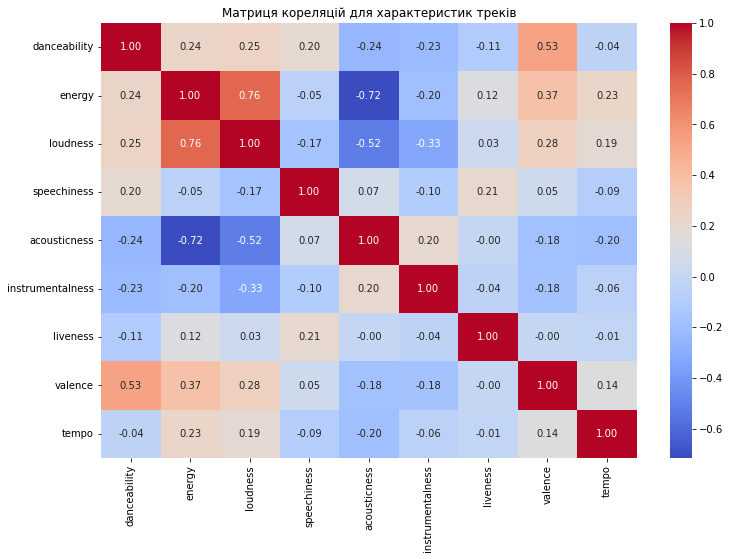

In [0]:
# Побудова heatmap з використанням seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матриця кореляцій для характеристик треків")
plt.show()

#### Рекомендаційна система. 
#### На основі даних про музичні треки створити просту рекомендаційну систему. Система повинна приймати один або кілька треків на вхід і повертати обмежену кількість рекомендацій на основі характеристик цих треків.


#### Ідея: Представити характеристики треків як елементи багатовимірного простору та побудувати рекомендації на основі відстані між елементами. Чим менша відстань - тим більш подібні треки.
#### Дизайн:
- Представити характеристики треків у вигляді векторів 
- Нормалізувати значення характеристик, щоб вони мали однаковий масштаб
- Застосувати метод головних компонент (PCA) для зменшення розмірності
- Розділити треки на кластери за допомою KMeans
- Обчислити відстань між треками всередині кластера та визначити "найближчі" до вхідного трека.

#### Підготовка даних: характеристики, векторизація, нормалізація

In [0]:
from pyspark.ml.feature import VectorAssembler, PCA, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import col, udf, lit
from pyspark.sql.types import DoubleType
import numpy as np
from pyspark.sql.functions import col, current_date, datediff, to_date, coalesce

# Додаємо нову характеристику: кількість днів з релізу
df = df.withColumn("release_date_fixed",coalesce(
        to_date(col("release_date"), "yyyy-MM-dd"),  
        to_date(col("release_date"), "yyyy") 
        )
)
df = df.withColumn("days_since_release", datediff(current_date(), col("release_date")))

# Список характеристик для нормалізації та PCA
features = ["danceability", "energy", "loudness", "speechiness", "acousticness", 
            "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "days_since_release"]

# Створення вектора характеристик
vector_col = "features"
assembler = VectorAssembler(inputCols=features, outputCol=vector_col)
df_vector = assembler.transform(df).select("id", "name", "artists", vector_col)

# Нормалізація даних
scaler = StandardScaler(inputCol=vector_col, outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector).select("id", "name", "artists", "scaled_features")

#### Зниження розмірності та кластеризація

In [0]:
# Застосування PCA для зниження розмірності до 3 компонент
pca = PCA(k=3, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled).select("id", "name", "artists", "pca_features")

# Створення моделі K-Means
kmeans = KMeans(featuresCol="pca_features", predictionCol="cluster", k=100)
kmeans_model = kmeans.fit(df_pca)

# Трансформування даних
df_clusters = kmeans_model.transform(df_pca)

#### Застосування: Визначення кластера для заданих характеристик

In [0]:
# Прогноз Кластера для Нового Треку

# Новий трек (приклад)
new_track = {
    "danceability": 0.8,
    "energy": 0.6,
    "loudness": -5.0,
    "speechiness": 0.05,
    "acousticness": 0.1,
    "instrumentalness": 0.0,
    "liveness": 0.15,
    "valence": 0.7,
    "tempo": 120.0, 
    "duration_ms": 100000,
    "days_since_release": 5000,
}

# Перетворення нового треку на DataFrame
new_track_df = spark.createDataFrame([new_track])

# Трансформування нового треку за допомогою VectorAssembler та PCA
new_track_vector = assembler.transform(new_track_df).select(vector_col)
new_track_scaled = scaler_model.transform(new_track_vector).select("scaled_features")
new_track_pca = pca_model.transform(new_track_scaled).select("pca_features")

# Прогноз кластера для нового треку
new_track_cluster = kmeans_model.transform(new_track_pca).select("cluster").head()[0]
print(f"Новий трек належить до кластера: {new_track_cluster}")

Новий трек належить до кластера: 10


#### Застосування: Пошук "найближчих" треків у визначеному кластері

In [0]:
# Пошук Найближчих Треків у Кластері

# Вибір треків у тому ж кластері
cluster_tracks = df_clusters.filter(col("cluster") == new_track_cluster).select("id", "name", "artists", "pca_features")

# Додавання нового треку з його PCA векторами
new_track_pca_df = new_track_pca.withColumn("id", lit("new_track"))

# Обчислення відстані від нового треку до всіх треків у кластері
cluster_tracks_cross = cluster_tracks.alias("df1").crossJoin(new_track_pca_df.alias("df2")) \
    .select(col("df1.id").alias("id1"), col("df1.pca_features").alias("features1"), col("df2.pca_features").alias("features2"), col("name"), col("artists"))

# Функція для обчислення евклідової відстані
def euclidean_distance(x, y):
    x = np.array(x)
    y = np.array(y)
    return float(np.sqrt(np.sum((x - y) ** 2)))

# Реєстрація UDF для обчислення евклідової відстані
udf_euclidean_distance = udf(euclidean_distance, DoubleType())

# Додавання колонки з евклідовою відстанню
cluster_tracks_distances = cluster_tracks_cross.withColumn("distance", udf_euclidean_distance(col("features1"), col("features2")))

# Вибір найближчих треків
recommended_tracks = cluster_tracks_distances.orderBy(col("distance").asc()).limit(10)
# Відображення результату
#recommended_tracks.select("id1", "name", "artists", "distance").show(truncate=False)

#### Застосування: агрегація результату

In [0]:
display(recommended_tracks.select("id1", "name", "artists", "distance"))

id1,name,artists,distance
6M6Tkjn7e4TTVXBpudaGxb,18 Plus,"['Afro Bros', 'Finest Sno']",0.02660714663205901
7nmNs5rnnuMRNmUB9ZucXk,Cafecito,['Carlos y Alejandra'],0.027644108174814632
7EvcJZcJ5RvAyNCgAWg5b9,Katse Kala,['Helena Paparizou'],0.03703797319501435
2xS5JB4c22hSkKcVxQtOeA,Gioca jouer,['Claudio Cecchetto'],0.03902018765690769
0F7FA14euOIX8KcbEturGH,Old Town Road,['Lil Nas X'],0.039542505819286124
3OBwsWvkcueKfRzUJuFeSl,Something New (feat. Ty Dolla $ign),"['Wiz Khalifa', 'Ty Dolla $ign']",0.03954774748445267
5pSvjjfsh34sLrkYSNGCl4,Down Under,['Men At Work'],0.04015081864410536
1e5aBqPxREGH4X3KSlVv5b,Sirpa (feat. Ulpu),"['Arttu Wiskari', 'Ulpu']",0.041936219657315935
7dpjEFoW2eSWIofFqUSQzN,Zelene Su Bile Oči Te,['Plavi Orkestar'],0.04318218446541541
30F5BxQOjeZtWKfSK8YW5K,Sirpa (feat. Ulpu),"['Arttu Wiskari', 'Ulpu']",0.04409099326466822


#### Застосування: визначення рекомендацій для групи треків із датасету <code>tracks</code>

In [0]:

# Пошук Схожих Треків для Групи Треків

# Вибір треків для яких потрібно знайти схожі (вказати їх ID)

#track_ids = ["4joiWvli4qJVEW6qZV2i2J", "6wfK1R6FoLpmUA9lk5ll4T", "7Msq9qojB7yORuJvz49iUy"]  
track_ids = ["1lCRw5FEZ1gPDNPzy1K4zW"]  

# Вибір характеристик обраних треків
selected_tracks = df_clusters.filter(col("id").isin(track_ids)).select("pca_features").collect()

# Обчислення середнього вектора характеристик
mean_vector = np.mean([row["pca_features"] for row in selected_tracks], axis=0)
mean_vector_udf = udf(lambda: Vectors.dense(mean_vector), VectorUDT())

# Прогноз Кластера для Середнього Вектора

# Перетворення середнього вектора на DataFrame
mean_vector_df = spark.createDataFrame([(Vectors.dense(mean_vector),)], ["pca_features"])

# Прогноз кластера для середнього вектора
mean_vector_cluster = kmeans_model.transform(mean_vector_df).select("cluster").head()[0]
print(f"Середній вектор належить до кластера: {mean_vector_cluster}")

Середній вектор належить до кластера: 7


In [0]:
# Пошук Найближчих Треків у Кластері для Середнього Вектора

# Вибір треків у тому ж кластері
cluster_tracks = df_clusters.filter(col("cluster") == mean_vector_cluster).select("id", "name", "artists", "pca_features")

# Додавання середнього вектора до DataFrame
mean_vector_pca_df = mean_vector_df.withColumn("id", lit("mean_vector"))

# Обчислення відстані від середнього вектора до всіх треків у кластері
cluster_tracks_cross = cluster_tracks.alias("df1").crossJoin(mean_vector_pca_df.alias("df2")) \
    .select(col("df1.id").alias("id1"), col("df1.pca_features").alias("features1"), col("df2.pca_features").alias("features2"), col("name"), col("artists"))

# Додавання колонки з евклідовою відстанню
cluster_tracks_distances = cluster_tracks_cross.withColumn("distance", udf_euclidean_distance(col("features1"), col("features2")))

# Вибір найближчих треків
recommended_tracks = cluster_tracks_distances.orderBy(col("distance").asc()).limit(50)

# Відображення результату
display(recommended_tracks.select("id1", "name", "artists", "distance"))

id1,name,artists,distance
6Wh00mhMuECTIzEHuICquU,We Are The Champions - Remastered 2011,['Queen'],0.0
1lCRw5FEZ1gPDNPzy1K4zW,We Are The Champions - Remastered 2011,['Queen'],0.0
7ccI9cStQbQdystvc6TvxD,We Are The Champions - Remastered 2011,['Queen'],0.009383056838321309
0z0gqCUMdkydEttZmKze1h,We Are The Champions,['Queen'],0.021748938860884144
5prXUVnzXFeUf5WsjVWXmx,Sunshine In Their Eyes,['Stevie Wonder'],0.024296252189725656
4OycN8ayb7nBlYYfwEb2ap,"Por Qué Te Fuiste ""Pa""",['José Velez'],0.028438206032361194
3bt7UPeoMsT7ix5tBk1gnF,Ne Zaman Gitti Tren,['Kesmeşeker'],0.04155290845328731
73bLM6IiZCpx526cbeGk28,Read 'Em and Weep,['Meat Loaf'],0.04364465608428666
3m86qx7aIeqFcYcQ1UXUvP,The Show Must Go On,['Queen'],0.04690212874073118
0pH4QNsSphVLCy9zjPzqiP,Ol' 55 - 2013 Remaster,['Eagles'],0.0555088174354753
